In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cwd_split = os.getcwd().split('/')

if cwd_split[-1] == "ai":
    higher_level_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
    os.chdir(higher_level_dir)
    print(f"changed to {higher_level_dir}")
elif cwd_split[-2] == "ai":
    higher_level_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))
    os.chdir(higher_level_dir)
    print(f"changed to {higher_level_dir}")

print(os.getcwd())


changed to /home/mrks/linux-Documents/efficientIO
/home/mrks/linux-Documents/efficientIO


### Effort to find best lower TH

Best ideas to implement
1) the highest value seen in the reference period (raw and averaged_mean)
2) By clustering with three centers

based on the function -> analyze_backing_monitor:
this shows a histogram which nicely seperates the 3 centers. 

#### Result
Based on 6 test cases
- clustering achieved 13 pts
- max of raw reference achieved 11 pts (was superior in one test case where the reference between nights changed)
- max of averaged reference achieved 1 pts

For the clustering algorithm it was not sufficient to just take the center between two clusters (factor = 2), 
but to elevate the th a little towards the direction of the lower center (factor = 2.25)

Also this method (factor = 2.25) was identified as best fit for the upper threshold.

In [2]:
from datetime import datetime, timedelta, time
import pandas as pd

from ai.utils.http_utils import fetch_data_from_http, append_data_to_dataframe_http
import os

projects = [
'638f6103-9d59-4c70-88ad-30aab513c47d',
'c31751ab-0ec6-434d-bdd4-ec062325205f',
'562a358b-9af8-4176-9baa-7b1562d8e524',
'4d0c34f6-242f-4ce1-92bd-2a764b070941',
'ef351b6e-8cb7-43ed-9945-e3881a3cf228',
'0bd2836e-ee9c-4130-8903-5450f0f5540d' # Anker Bahnhofcity
]


v = 'prgEM.lr_RealPower_Grid'
# opening times (read from project settings)
# closing times (read from project settings)
# mocked
t_open = time(3,0)
t_closing = time(20,00)

# “bake window” timeframe (numeric input field, in minutes)
bake_window = 180

In [3]:
def get_load_periods(open_period_df: pd.DataFrame, open_period_mean: float):
    backing_periods = []
    start = None

    for index, row in open_period_df.iterrows():
        if row["Rolling Max"] > open_period_mean:
            if start is None:
                start = row.name
        elif not start is None:
            backing_periods.append((start, row.name))
            start = None
    return backing_periods

In [4]:
import numpy as np
from sklearn.cluster import KMeans

def get_tresholds(df, factor):
    # Generate some example data
    data = df["Rolling Mean"].dropna().values.reshape(-1,1)
    # Define the number of clusters (in this case, 2)
    num_clusters = 3

    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Sort the centroids
    centroids_sorted = np.sort(centroids, axis=0)

    # The threshold will be the midpoint between the two centroids
    threshold = [(centroids_sorted[0] + centroids_sorted[1]) / factor,
                (centroids_sorted[1] + centroids_sorted[2]) / factor]


    print("Threshold:", threshold)
    return threshold


In [5]:
def plot_backing_monitoring(operation_start, operation_stop, load_periods, ths):
    import matplotlib.pyplot as plt

    # Plot the DataFrame
    plt.figure(figsize=(10, 6))

    # Plot DataFrame as a scatter plot
    plt.plot(df, label='DataFrame')

    # Plot the float value as a horizontal line
    plt.axhline(y=operating_mean, color='g', linestyle='-')
    plt.axhline(y=operating_mean_roll, color='r', linestyle='--')

    plt.axhline(y=closed_hours_max, color='g', linestyle='-')
    plt.axhline(y=closed_hours_mean, color='r', linestyle='-')
    plt.axhline(y=th1, color='g', linestyle='--')

    plt.axhline(ths[0], color='g', linestyle='--')
    plt.axhline(ths[1], color='g', linestyle='-')


    #plt.axhline(y=operating_min_roll, color='b', linestyle='--')
    #plt.axhline(y=operating_max_roll, color='y', linestyle='--')



    plt.axvspan(operation_start, operation_stop, color='lightgray')

    for item in load_periods:
        plt.axvspan(item[0], item[1], color='yellow')



    # Show the plot
    plt.grid(False)
    plt.show()

In [6]:
def analyze_load_monitoring(ths, ref):
    plt.figure(figsize=(10, 10))

    plt.subplot(411)
    df["Rolling Mean"].plot()
    plt.axhline(ths[0], color='g', linestyle='--')
    plt.axhline(ths[1], color='g', linestyle='-')
    plt.axhline(ref, color='r', linestyle='--')

    
    plt.subplot(412)
    plt.plot(np.gradient(df["Rolling Mean"].values))

    plt.subplot(413)
    st = np.sort(df["Rolling Mean"].values)
    st_grad = np.gradient(st)
    plt.plot(st)
    plt.plot(st_grad*10)

    plt.subplot(414)
    _ = plt.hist(st, bins=30)  # arguments are passed to np.histogram
    plt.show()

ANAYLISIS FOR PROJECT: 638f6103-9d59-4c70-88ad-30aab513c47d


/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Threshold: [array([5.33463196]), array([10.65122693])]
Threshold: [array([4.26770556]), array([8.52098155])]
Threshold: [array([4.74189507]), array([9.46775727])]
ANAYLISIS FOR PROJECT: c31751ab-0ec6-434d-bdd4-ec062325205f


/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Threshold: [array([4.86810831]), array([9.38412106])]
Threshold: [array([3.89448664]), array([7.50729685])]
Threshold: [array([4.32720738]), array([8.34144094])]
ANAYLISIS FOR PROJECT: 562a358b-9af8-4176-9baa-7b1562d8e524


/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Threshold: [array([23.46761425]), array([34.48140745])]
Threshold: [array([18.7740914]), array([27.58512596])]
Threshold: [array([20.86010155]), array([30.65013996])]
ANAYLISIS FOR PROJECT: 4d0c34f6-242f-4ce1-92bd-2a764b070941


/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Threshold: [array([5.11464191]), array([10.65977743])]
Threshold: [array([4.09171353]), array([8.52782194])]
Threshold: [array([4.54634836]), array([9.47535771])]
ANAYLISIS FOR PROJECT: ef351b6e-8cb7-43ed-9945-e3881a3cf228


/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Threshold: [array([4.70746659]), array([8.54311302])]
Threshold: [array([3.76224339]), array([6.83293957])]
Threshold: [array([4.18027044]), array([7.59215508])]
ANAYLISIS FOR PROJECT: 0bd2836e-ee9c-4130-8903-5450f0f5540d


/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mrks/miniconda3/envs/py3117/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Threshold: [array([5.4650226]), array([11.18145363])]
Threshold: [array([4.37201808]), array([8.9451629])]
Threshold: [array([4.85779787]), array([9.93906989])]


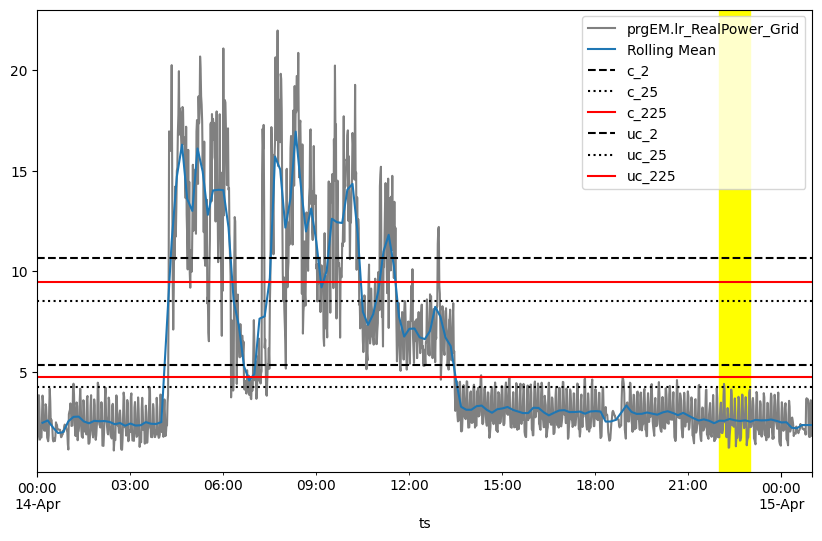

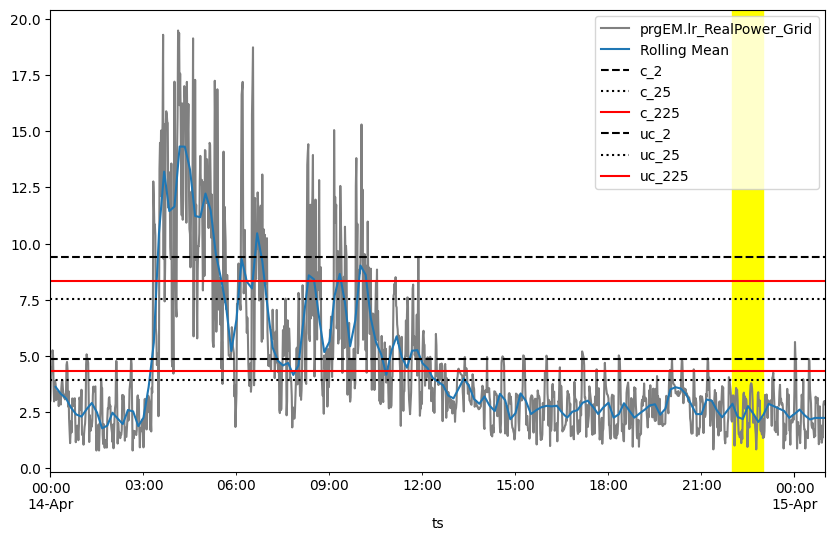

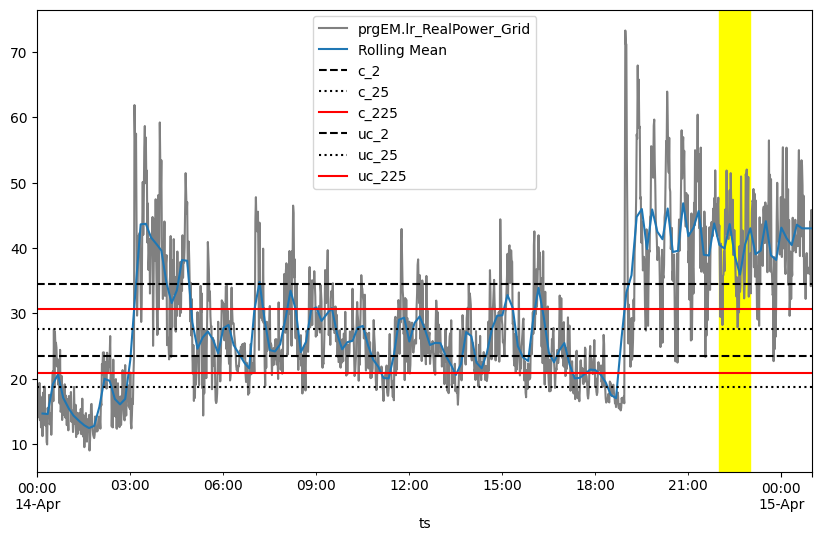

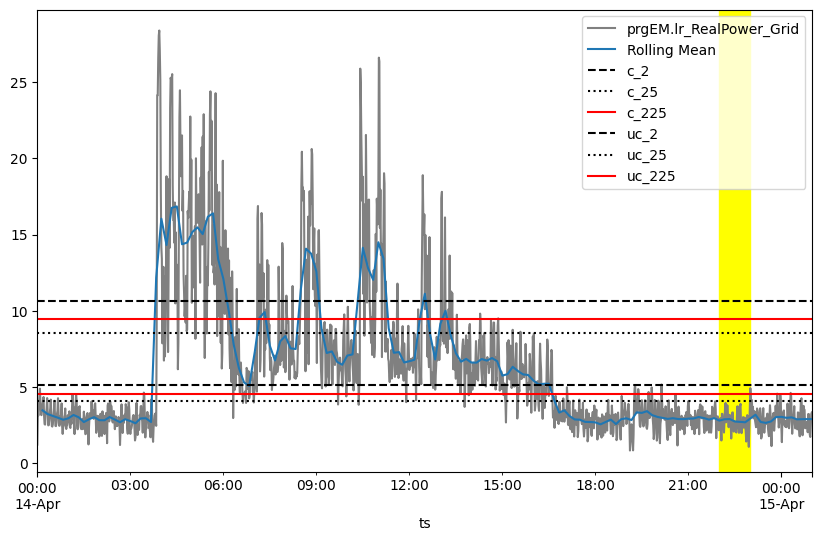

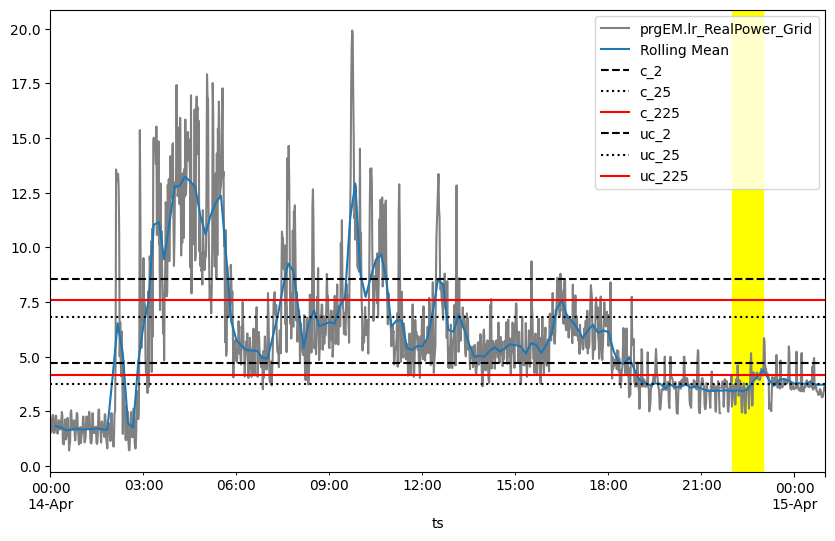

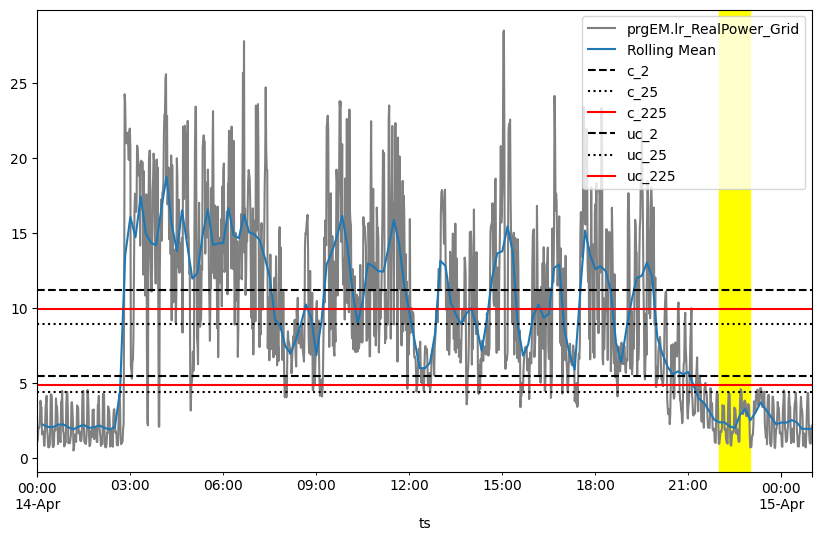

In [35]:

import pytz

def dt_to_ts(dt: datetime):
    return int(dt.timestamp())

def datetime_add_timezone(standard_datetime: datetime):
    # Convert to datetime64[ns, CET]
    standard_datetime = standard_datetime - timedelta(hours=2)
    cet_timezone = pytz.timezone('CET')
    datetime_cet = pd.to_datetime(standard_datetime, utc=True).tz_convert(cet_timezone)
    return datetime_cet

for project_id in projects:
    v = 'prgEM.lr_RealPower_Grid'

    print(f'ANAYLISIS FOR PROJECT: {project_id}')

    analyze_day_offset = 0
    reference_time = [22,23]
    
    today = datetime.today()-timedelta(days=analyze_day_offset)
    analyze_day = datetime.today()-timedelta(days=analyze_day_offset+1)


    start_dt = datetime_add_timezone(analyze_day)
    end_dt = datetime_add_timezone(today)

    t_ref_start =  datetime_add_timezone(datetime.combine(start_dt, time(reference_time[0],0)))
    t_ref_end =  datetime_add_timezone(datetime.combine(start_dt, time(reference_time[1],0)))


    # define analysis period
    start_dt = start_dt.replace(hour = 0, minute = 0, second= 0, microsecond = 0)
    end_dt = end_dt.replace(hour = 1, minute = 0, second= 0, microsecond = 0)

    start_ts = int(start_dt.timestamp())
    end_ts = int(end_dt.timestamp())


    df = pd.DataFrame()

    data = fetch_data_from_http(v, project_id, start_ts, end_ts, "1m")
    df = append_data_to_dataframe_http(df, data, v)
    df = df.set_index("ts")

    df['Rolling Mean'] = df[v].rolling(window=21, step=10, center=True).mean()
    df['Rolling Mean'] = df['Rolling Mean'].interpolate('linear')

    # max value reference period of averaged mean
    reference_max = df[(df.index > t_ref_start) & 
                       (df.index < t_ref_end)]["Rolling Mean"].max()
    
    # max value reference period of raw
    reference_max_v = df[(df.index > t_ref_start) & 
                       (df.index < t_ref_end)][v].max()
    
    # threshold determined by clustering
    ths_2 = get_tresholds(df, 2)
    ths_25 = get_tresholds(df, 2.5)
    ths_225 = get_tresholds(df, 2.25)

    
    plt.figure(figsize=(10, 6))
    #plt.plot(df)
    
    
    #analyze_load_monitoring(ths, reference_max)

    df[v].plot(color="gray")
    df["Rolling Mean"].plot()
    plt.axvspan(t_ref_start, t_ref_end, color='yellow')

    plt.axhline(ths_2[0], color='black', linestyle='--', label="c_2")
    plt.axhline(ths_25[0], color='black', linestyle=':', label="c_25")
    plt.axhline(ths_225[0], color='red', linestyle='-', label="c_225")

    plt.axhline(ths_2[1], color='black', linestyle='--', label="uc_2")
    plt.axhline(ths_25[1], color='black', linestyle=':', label="uc_25")
    plt.axhline(ths_225[1], color='red', linestyle='-', label="uc_225")

    #plt.axhline(reference_max_v, color='r', linestyle='-', label="ref_v")
    plt.legend()

    
    
    continue


    closed_hours_max = df[df.index > end_dt-timedelta(hours=2)].max().iloc[0]
    closed_hours_mean = df[df.index > end_dt-timedelta(hours=2)].mean().iloc[0]
    closed_hours_std = df[df.index > end_dt-timedelta(hours=2)].std().iloc[0]


    # add the rolling mean
    df['Rolling Mean'] = df[v].rolling(window=3).mean()




